In [36]:
import numpy as np #linear algebra 
import pandas as pd #data processing



In [37]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
!unzip brain-tumor-mri-dataset.zip


Archive:  brain-tumor-mri-dataset.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Testing/glioma/Te-glTr_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-glTr_0001.jpg  
replace Testing/glioma/Te-glTr_0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-glTr_0002.jpg  
replace Testing/glioma/Te-glTr_0003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-glTr_0003.jpg  
replace Testing/glioma/Te-glTr_0004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-glTr_0004.jpg  
replace Testing/glioma/Te-glTr_0005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-glTr_0005.jpg  
replace Testing/glioma/Te-glTr_0006.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-glTr_0006.jpg  
replace Testing/glioma/Te-glTr_0007.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma/Te-g

In [39]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from glob import glob 
import glob2
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from PIL import Image, ImageEnhance
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [42]:
warnings.filterwarnings("ignore")

In [43]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 31 16:50:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   9067MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
!ls


brain-tumor-mri-dataset.zip  mriscans.h5  Testing
model_architecture.png	     sample_data  Training


In [12]:
train = "/content/Training"
print(os.listdir("/content/Training"))
test = "/content/Testing"
print(os.listdir("/content/Testing"))

['glioma', 'meningioma', 'pituitary', 'notumor']
['glioma', 'meningioma', 'pituitary', 'notumor']


In [13]:
for labels in  os.listdir(train) : 
    files = glob(pathname= str( train +'//' + labels + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {labels}')

For training data , found 1321 in folder glioma
For training data , found 1339 in folder meningioma
For training data , found 1457 in folder pituitary
For training data , found 1595 in folder notumor


In [14]:
for labels in  os.listdir(test) : 
    files = glob(pathname= str( test +'//' + labels + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {labels}')

For training data , found 300 in folder glioma
For training data , found 306 in folder meningioma
For training data , found 300 in folder pituitary
For training data , found 405 in folder notumor


In [58]:

X_train = []
Y_train = []

image_size = 150
labels = ['glioma','meningioma','notumor','pituitary']
for i in labels:
  folderpath = os.path.join('/content/Training',i)
  for j in os.listdir(folderpath):
    img = cv2.imread(os.path.join(folderpath,j))
    img = cv2.resize(img, (image_size,image_size))
    X_train.append(img)
    Y_train.append(i)

for i in labels:
  folderpath = os.path.join('/content/Testing',i)
  for j in os.listdir(folderpath):
    img = cv2.imread(os.path.join(folderpath,j))
    img = cv2.resize(img, (image_size,image_size))
    X_train.append(img)
    Y_train.append(i)




In [60]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train, Y_train = shuffle(X_train, Y_train, random_state = 101)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 101)


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

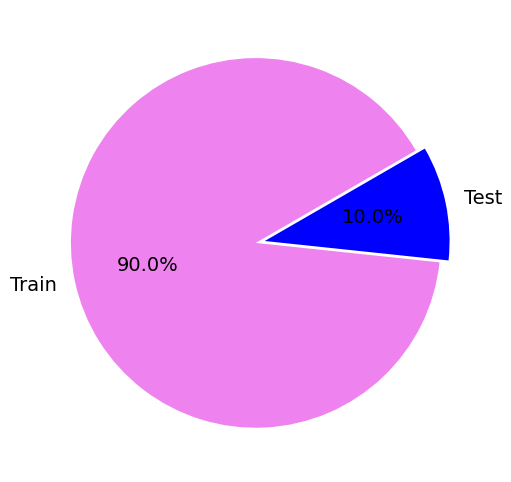

In [61]:
def plot_split():
  plt.figure(figsize=(14,6))
  colors = ['Violet' , 'Blue']
  plt.rcParams.update({'font.size': 14})
  plt.pie([len(x_train), len(x_test)],
  labels=['Train','Test'],
  colors=colors, autopct='%.1f%%', explode=(0.05,0),
  startangle=30);

plot_split()

In [62]:
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

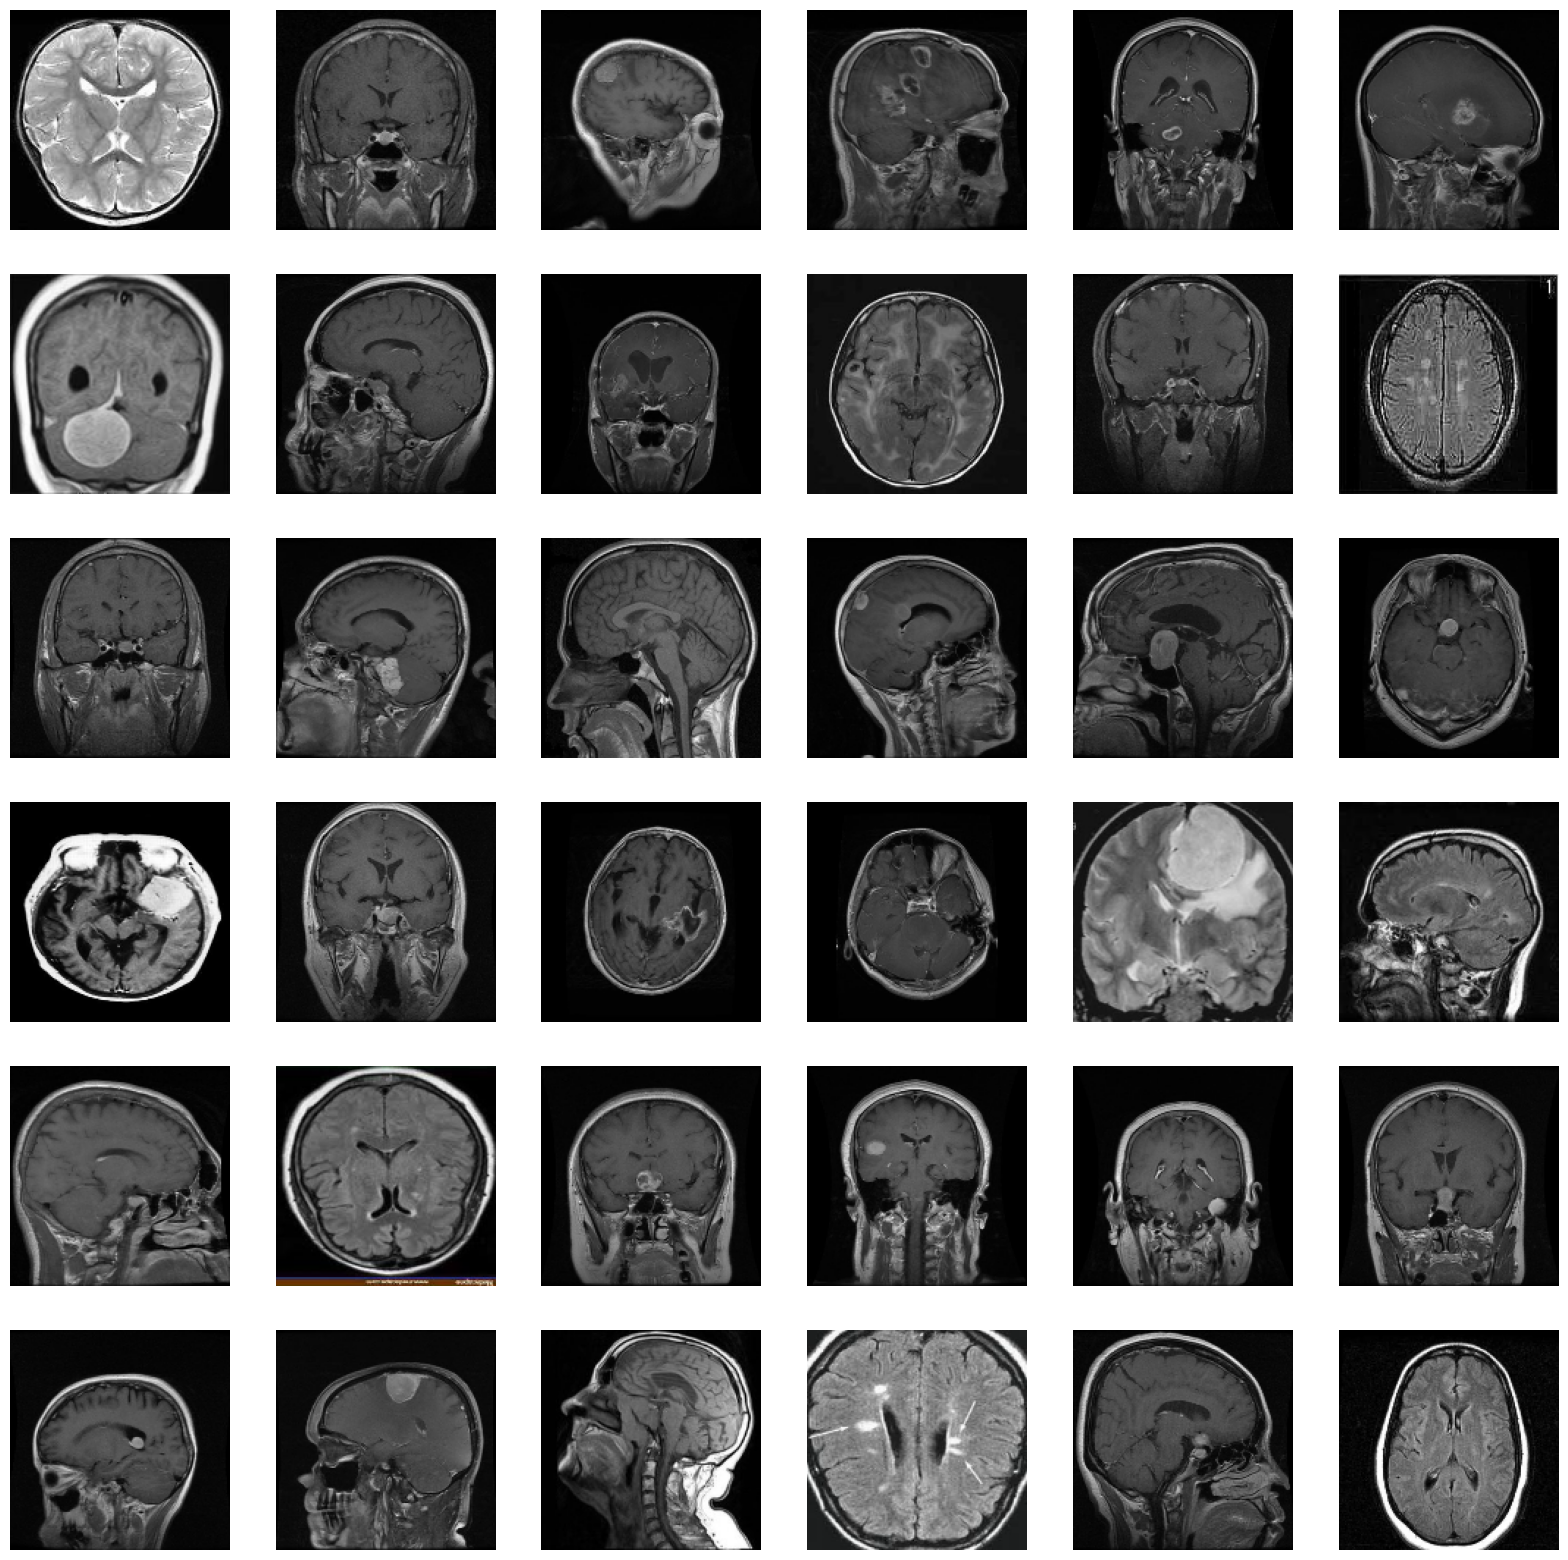

In [63]:
def sample_scans():
  plt.figure(figsize=(20,20))
  for n , i in enumerate(list(np.random.randint(0,len(x_train),36))) : 
      plt.subplot(6,6,n+1)
      plt.imshow(x_train[i])    
      plt.axis('off')
sample_scans()

In [64]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # Updated the number of units to 4 and used 'softmax' activation
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



In [65]:
print('Model Details are : ')
print(model.summary())

Model Details are : 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_28 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 73, 73, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 conv2d_30 (Conv2D)          (None, 69, 69, 64)        36928     
                                 

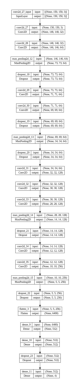

In [66]:
# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Display the model architecture plot
image = plt.imread('model_architecture.png')
plt.imshow(image)
plt.axis('off')
plt.show()

In [68]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

history = model.fit(datagen.flow(x_train, y_train),epochs=100,validation_data=(x_val, y_val))

Epoch 1/100
178/178 [==============================] - 39s 199ms/step - loss: 1.6868 - accuracy: 0.3683 - val_loss: 1.2831 - val_accuracy: 0.3766
Epoch 2/100
178/178 [==============================] - 33s 186ms/step - loss: 1.1118 - accuracy: 0.4710 - val_loss: 1.3314 - val_accuracy: 0.3544
Epoch 3/100
178/178 [==============================] - 34s 189ms/step - loss: 0.9969 - accuracy: 0.5759 - val_loss: 1.2339 - val_accuracy: 0.4114
Epoch 4/100
178/178 [==============================] - 34s 188ms/step - loss: 0.9384 - accuracy: 0.6060 - val_loss: 1.0732 - val_accuracy: 0.5443
Epoch 5/100
178/178 [==============================] - 33s 185ms/step - loss: 0.8853 - accuracy: 0.6254 - val_loss: 1.0186 - val_accuracy: 0.5791
Epoch 6/100
178/178 [==============================] - 33s 185ms/step - loss: 0.8731 - accuracy: 0.6375 - val_loss: 0.8518 - val_accuracy: 0.6234
Epoch 7/100
178/178 [==============================] - 33s 186ms/step - loss: 0.7974 - accuracy: 0.6718 - val_loss: 1.0870 -

In [69]:
model.save('mriscans.h5')

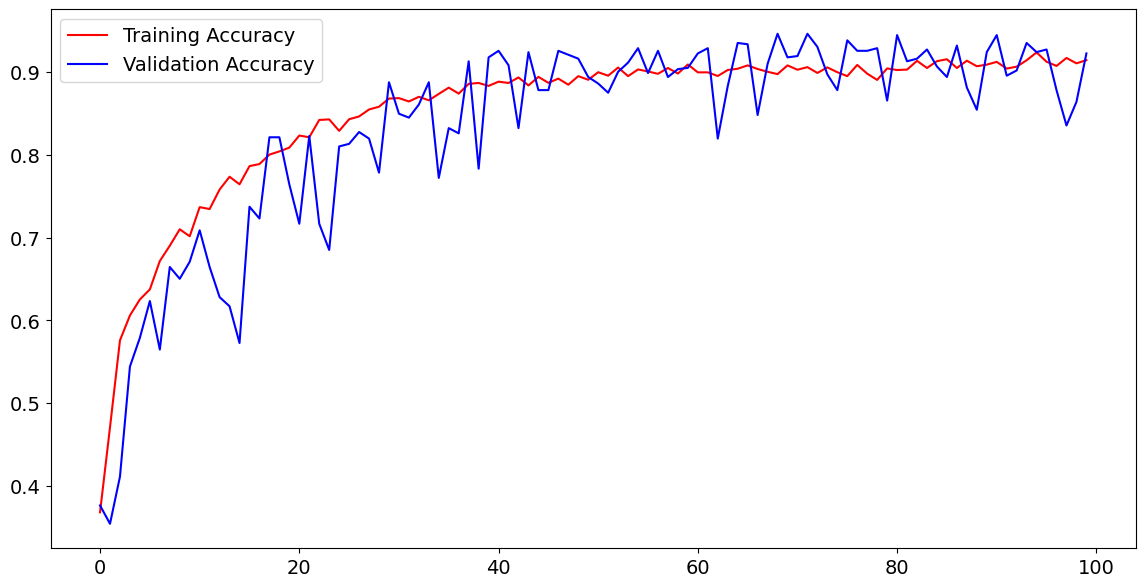

In [70]:
def train_vs_valid():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  fig = plt.figure(figsize=(14,7))
  plt.plot(epochs,acc,'r',label="Training Accuracy")
  plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
  plt.legend(loc='upper left')
  plt.show()

train_vs_valid()

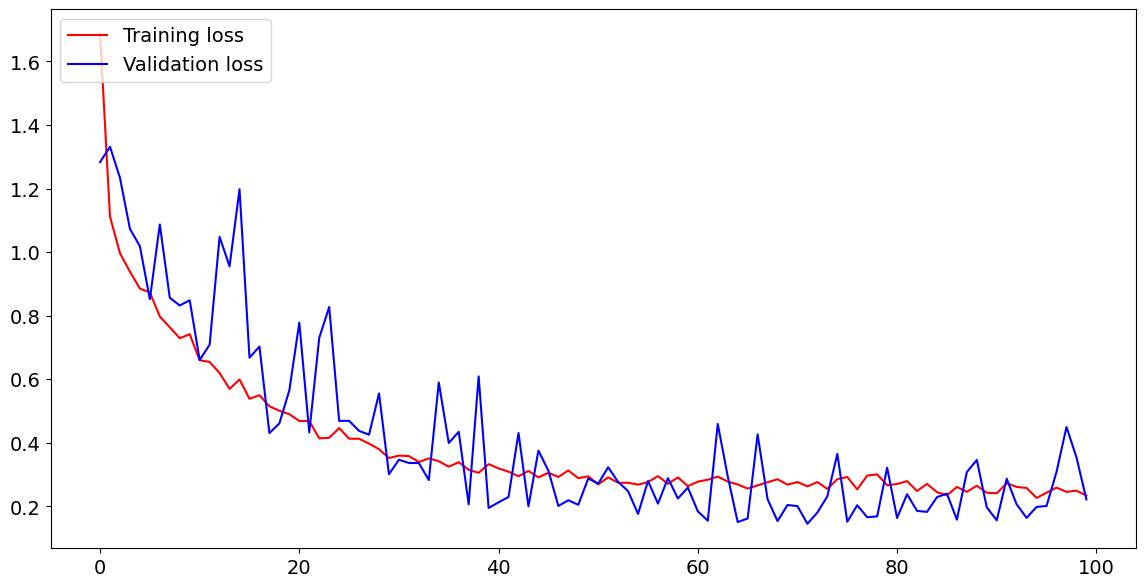

In [71]:
def loss():
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  fig = plt.figure(figsize=(14,7))
  plt.plot(epochs,loss,'r',label="Training loss")
  plt.plot(epochs,val_loss,'b',label="Validation loss")
  plt.legend(loc='upper left')
  plt.show()

loss()

**Data Evaluation**

In [74]:

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Check the format of true labels and convert them accordingly
if y_test.ndim > 1 and y_test.shape[1] > 1:
    # Multilabel format, convert to multiclass
    y_test = np.argmax(y_test, axis=1)
else:
    # Multiclass format, no conversion needed
    y_test = y_test
predict()
# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
report_df.to_csv('evaluation_report.csv', index=False)

22/22 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       155
           1       0.91      0.77      0.83       163
           2       0.94      0.98      0.96       214
           3       0.90      0.95      0.93       171

    accuracy                           0.91       703
   macro avg       0.91      0.90      0.90       703
weighted avg       0.91      0.91      0.91       703



22/22 [==============================] - 0s 22ms/step


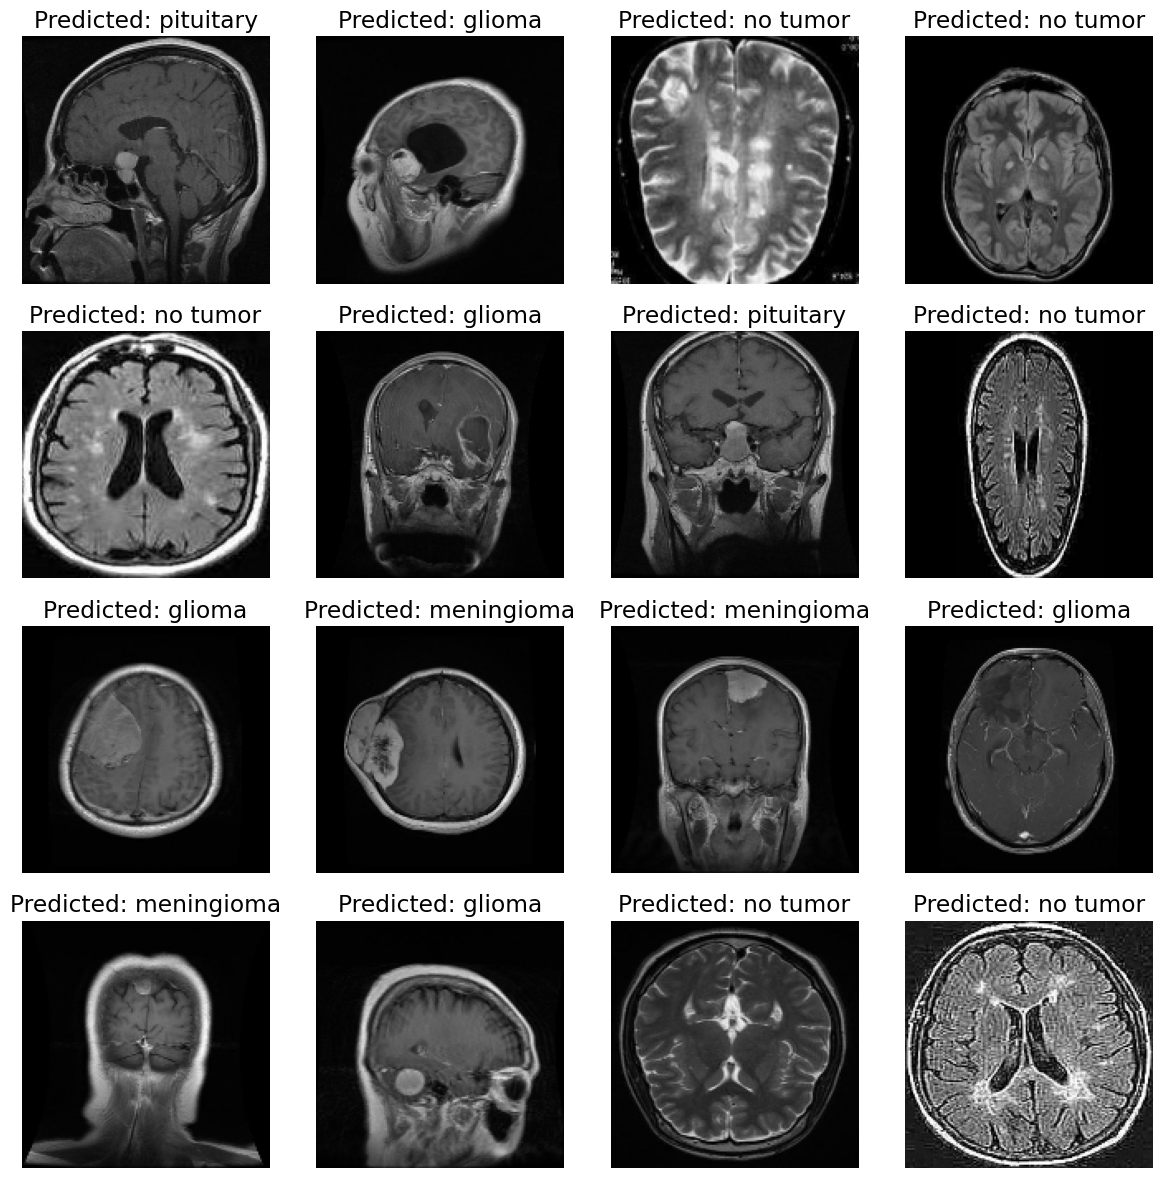

In [75]:
def show_predictions():
  predictions = model.predict(x_test)
  predicted_labels = np.argmax(predictions, axis=1)

  # Define the label mapping dictionary
  label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'no tumor', 3: 'pituitary'}  # Add more labels if needed

  # Display a subset of the images and predictions
  num_images = len(x_test)
  num_display = 16  # Number of images to display
  display_indices = np.random.choice(num_images, size=num_display, replace=False)

  # Create the figure and subplots
  num_rows = int(np.ceil(num_display / 4))
  fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3*num_rows))

  # Iterate through the display indices and show the images and predictions
  for i, ax in enumerate(axes.flat):
      img_index = display_indices[i]
      ax.imshow(x_test[img_index])  # Assuming X_test contains the images in the appropriate format
      ax.axis('off')
      predicted_class = label_mapping[predicted_labels[img_index]]
      ax.set_title(f"Predicted: {predicted_class}")

  plt.tight_layout()
  plt.show()
show_predictions()

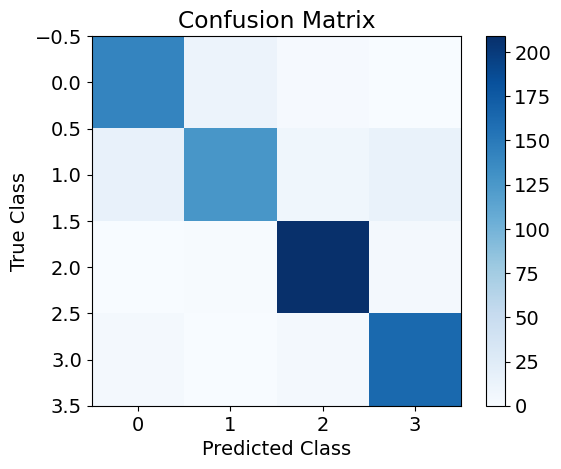

In [77]:
# Create confusion matrix

def confusionmatrix():
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix
  plt.imshow(cm, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.show()
confusionmatrix()

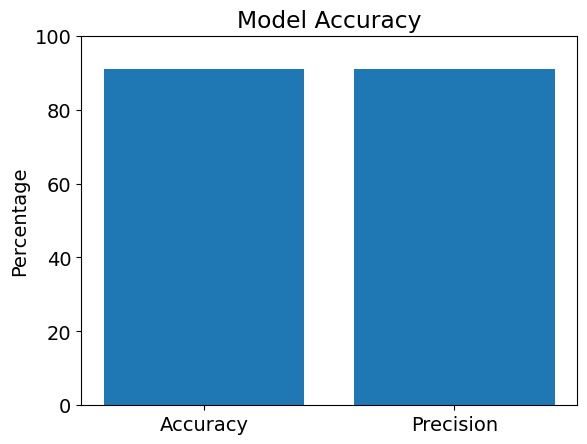

In [78]:
def accuracy_vs_precision():
  accuracy = accuracy_score(y_test, y_pred)
  accuracy_percentage = accuracy * 100
  precision = precision_score(y_test, y_pred, average='weighted')
  precision_percentage = precision * 100
  # Print the accuracy percentage
  # Plot accuracy and precision
  labels = ['Accuracy', 'Precision']
  values = [accuracy * 100, precision * 100]
  plt.bar(labels, values)
  plt.ylim([0, 100])
  plt.ylabel('Percentage')
  plt.title('Model Accuracy')
  plt.show()
accuracy_vs_precision()

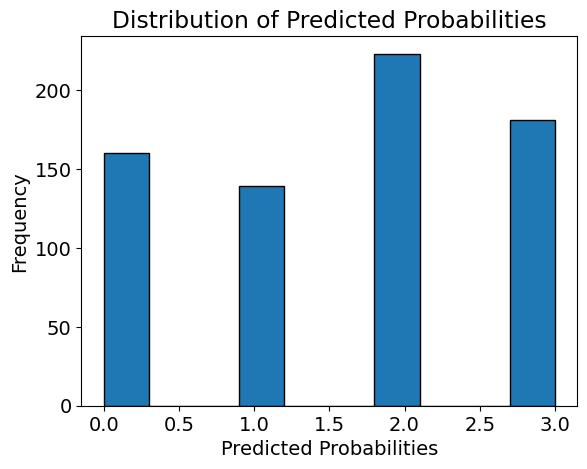

In [79]:
def pred_probabilities():
  # Plot the histogram
  plt.hist(y_pred, bins=10, edgecolor='black')
  plt.xlabel('Predicted Probabilities')
  plt.ylabel('Frequency')
  plt.title('Distribution of Predicted Probabilities')
  plt.show()
pred_probabilities()